# Report

## Table of contents
* [Introduction/Business Problem](#intro)
* [Data](#data)
* [Methodology](#method)
* [Results](#res)
* [Discussion](#disc)
* [Conclusion](#concl)

## Introduction/Business Problem <a id="intro"></a>

### Problem
Develop a "Living Index" - a rating for each neighbourhood of Toronto that uses combination of factors that influence how suitable the area is for living there. For instance, "Living Index" for The Beaches could be 9.1 (out of 10), whereas "Rustic" could have 3.2.

The developed system would help people that plan to move to Toronto to select area where to live.

### Target audience
Any user around the world that intends to move to Toronto, or just curious.

### Living Index
Living index will combine a number of factors to come up with overall result. Those factors (including, but not limited to): distance to malls, distance to schools (rated), distance to food points (cafes, restaurants, etc.), public transport, crime rates, etc.

### Leverage Foursquare
Wherever possible, Foursquare will be used to retrieve data for neighbourhoods (such as school locations, restaurants, cinemas, etc.).

## Data <a id="data"></a>

1. Neighbourhood data with locations (scraped from Wikipedia and with geo data added).

    Example:

    ![Neighbourhood data](images/neigh_data.png)

2. Foursquare

    Foursquare API will be used to retrieve data about locations of important businesses, etc.

    * School locations with reviews
    * Restaurant locations with reviews
    * Businesses locations

    Example:

    ```bash
    curl -X GET -G \
        'https://api.foursquare.com/v2/venues/explore' \
            -d client_id="CLIENT_ID" \
            -d client_secret="CLIENT_SECRET" \
            -d v="20180323" \
            -d ll="40.7243,-74.0018" \
            -d query="coffee" \
            -d limit=1
    ```

3. Toronto Police Data from Kaggle:
    [Reports and files on Major Crimes and Location](https://www.kaggle.com/kapastor/toronto-police-data-crime-rates-by-neighbourhood)

    This dataset contains records for crimes that ocurred in Toronto from 2014 to 2019, with the information on their locations and types.

    Example:

    ![crime data](images/crime_data.png)

## Methodology <a id="method"></a>

Methodology section represents the main component of the report where we discuss and describe any exploratory data analysis that we did, any inferential statistical testing that we performed, if any, and what machine learnings were used and why.

In [1]:
import pandas as pd
import numpy as np

### Exploratory Data Analysis

In [4]:
neighbourhoods = pd.read_csv("toronto_neighbourhoods.csv")
print(neighbourhoods.shape)
neighbourhoods.head()

(103, 5)


Postal Code      Borough                           Neighbourhood   Latitude  \
0         M1B  Scarborough                          Malvern, Rouge  43.806686   
1         M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2         M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3         M1G  Scarborough                                  Woburn  43.770992   
4         M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [20]:
police_data = pd.read_csv("MCI_2014_to_2019.csv")
print(police_data.shape)
police_data.head(2)

(206435, 29)


X          Y  Index_ event_unique_id            occurrencedate  \
0 -79.405228  43.656982    7801  GO-20152165447  2015-12-18T03:58:00.000Z   
1 -79.307907  43.778732    7802  GO-20151417245  2015-08-15T21:45:00.000Z   

               reporteddate premisetype  ucr_code  ucr_ext  offence  ...  \
0  2015-12-18T03:59:00.000Z  Commercial      1430      100  Assault  ...   
1  2015-08-17T22:11:00.000Z  Commercial      1430      100  Assault  ...   

   occurrencedayofyear occurrencedayofweek  occurrencehour      MCI Division  \
0                352.0          Friday                   3  Assault      D14   
1                227.0          Saturday                21  Assault      D42   

   Hood_ID                 Neighbourhood       Long        Lat  ObjectId  
0       79               University (79) -79.405228  43.656982      7001  
1      118  Tam O'Shanter-Sullivan (118) -79.307907  43.778732      7002  

[2 rows x 29 columns]

First, let's make sure the datatypes are correct for the columns. Also, drop non-interesting columns.

In [21]:
columns = ["Lat", "Long", "Neighbourhood", "X", "Y", "occurrencedate", "offence", "MCI"]
police_data = police_data[columns]
police_data["occurrencedate"] = pd.to_datetime(police_data["occurrencedate"])
police_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206435 entries, 0 to 206434
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   Lat             206435 non-null  float64            
 1   Long            206435 non-null  float64            
 2   Neighbourhood   206435 non-null  object             
 3   X               206435 non-null  float64            
 4   Y               206435 non-null  float64            
 5   occurrencedate  206435 non-null  datetime64[ns, UTC]
 6   offence         206435 non-null  object             
 7   MCI             206435 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(4), object(3)
memory usage: 12.6+ MB


In [22]:
police_data.describe(include='all', datetime_is_numeric=True)

Lat           Long                           Neighbourhood  \
count   206435.000000  206435.000000                                  206435   
unique            NaN            NaN                                     140   
top               NaN            NaN  Waterfront Communities-The Island (77)   
freq              NaN            NaN                                    7747   
mean        43.707379     -79.394940                                     NaN   
min         43.587093     -79.639267                                     NaN   
25%         43.661152     -79.471481                                     NaN   
50%         43.701328     -79.393333                                     NaN   
75%         43.752068     -79.319374                                     NaN   
max         43.850788     -79.123100                                     NaN   
std          0.052718       0.104386                                     NaN   

                    X              Y                       occurrencedate  \
count   206435.000000  206435.000000                               206435   
unique            NaN            NaN                                  NaN   
top               NaN            NaN                                  NaN   
freq              NaN            NaN                                  NaN   
mean       -79.394940      43.707379  2017-01-30 02:54:45.299586048+00:00   
min        -79.639267      43.587093            1966-06-09 00:00:00+00:00   
25%        -79.471481      43.661152            2015-08-08 19:22:30+00:00   
50%        -79.393333      43.701328            2017-03-02 21:45:00+00:00   
75%        -79.319374      43.752068            2018-08-17 17:00:00+00:00   
max        -79.123100      43.850788            2019-12-31 23:47:00+00:00   
std          0.104386       0.052718                                  NaN   

        offence      MCI  
count    206435   206435  
unique       49        5  
top     Assault  Assault  
freq      76124   111423  
mean        NaN      NaN  
min         NaN      NaN  
25%         NaN      NaN  
50%         NaN      NaN  
75%         NaN      NaN  
max         NaN      NaN  
std         NaN      NaN

Let's remove the numbers for each neighbourhoods.

In [27]:
police_data["Neighbourhood"] = police_data["Neighbourhood"].str.replace(r" \(\d+\)", "", regex=True)

Let's see what kinds of neighbourhoods there are in crime data.

In [29]:
police_data["Neighbourhood"].unique()[:10]

array(['University', "Tam O'Shanter-Sullivan", 'Woburn',
       'Centennial Scarborough', 'Taylor-Massey', 'Broadview North',
       'Bay Street Corridor', 'West Humber-Clairville',
       'Forest Hill North', 'Downsview-Roding-CFB'], dtype=object)

In [92]:
postal_codes = {}

postal_codes_crimes = []

for _, x in police_data.iterrows():
    if x["Neighbourhood"] not in postal_codes:
        for _, y in neighbourhoods.iterrows():
            if x["Neighbourhood"] in y["Neighbourhood"].split(", "):
                postal_codes[x["Neighbourhood"]] = y["Postal Code"]

    if x["Neighbourhood"] not in postal_codes:
        # Not already found, then look up the closes neighbourhood.
        closest = ((neighbourhoods["Latitude"] - x["Lat"]) ** 2 + (neighbourhoods["Longitude"] - x["Long"]) ** 2).argsort()[:1]
        postal_codes[x["Neighbourhood"]] = neighbourhoods.iloc[closest]["Postal Code"].iloc[0]

    postal_codes_crimes.append(postal_codes[x["Neighbourhood"]])

police_data["Postal Code"] = postal_codes_crimes

# display(postal_codes)
display(police_data.head(2))

Lat       Long           Neighbourhood          X          Y  \
0  43.656982 -79.405228              University -79.405228  43.656982   
1  43.778732 -79.307907  Tam O'Shanter-Sullivan -79.307907  43.778732   

             occurrencedate  offence      MCI Postal Code  
0 2015-12-18 03:58:00+00:00  Assault  Assault         M5T  
1 2015-08-15 21:45:00+00:00  Assault  Assault         M1T

Lets get crime counts per neighbourhood and visualize a heatmap.

In [72]:
neighbourhood_crimes = police_data[["Postal Code", "offence"]].groupby(["Postal Code"]).count().reset_index()
neighbourhood_crimes["offence"] = neighbourhood_crimes["offence"] / (neighbourhood_crimes["offence"].sum())
neighbourhood_crimes.rename(columns={"offence": "CrimeRate"}, inplace=True)
neighbourhood_crimes.head()

Postal Code  CrimeRate
0         M1B   0.022603
1         M1C   0.005929
2         M1E   0.024962
3         M1G   0.018398
4         M1J   0.016436

In [75]:
neighbourhood_crimes = neighbourhoods.merge(neighbourhood_crimes, on="Postal Code")
neighbourhood_crimes.head()

Postal Code      Borough                           Neighbourhood   Latitude  \
0         M1B  Scarborough                          Malvern, Rouge  43.806686   
1         M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2         M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3         M1G  Scarborough                                  Woburn  43.770992   
4         M1J  Scarborough                     Scarborough Village  43.744734   

   Longitude  CrimeRate  
0 -79.194353   0.022603  
1 -79.160497   0.005929  
2 -79.188711   0.024962  
3 -79.216917   0.018398  
4 -79.239476   0.016436

Visualize on a map.

In [77]:
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [74]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [91]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

data = neighbourhood_crimes[["Latitude", "Longitude", "CrimeRate"]].values

HeatMap(data).add_to(folium.FeatureGroup(name='Heat Map').add_to(map_toronto))
folium.LayerControl().add_to(map_toronto)
    
# add markers to map
for lat, lng, borough, neighbourhood in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Borough'], neighbourhoods['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

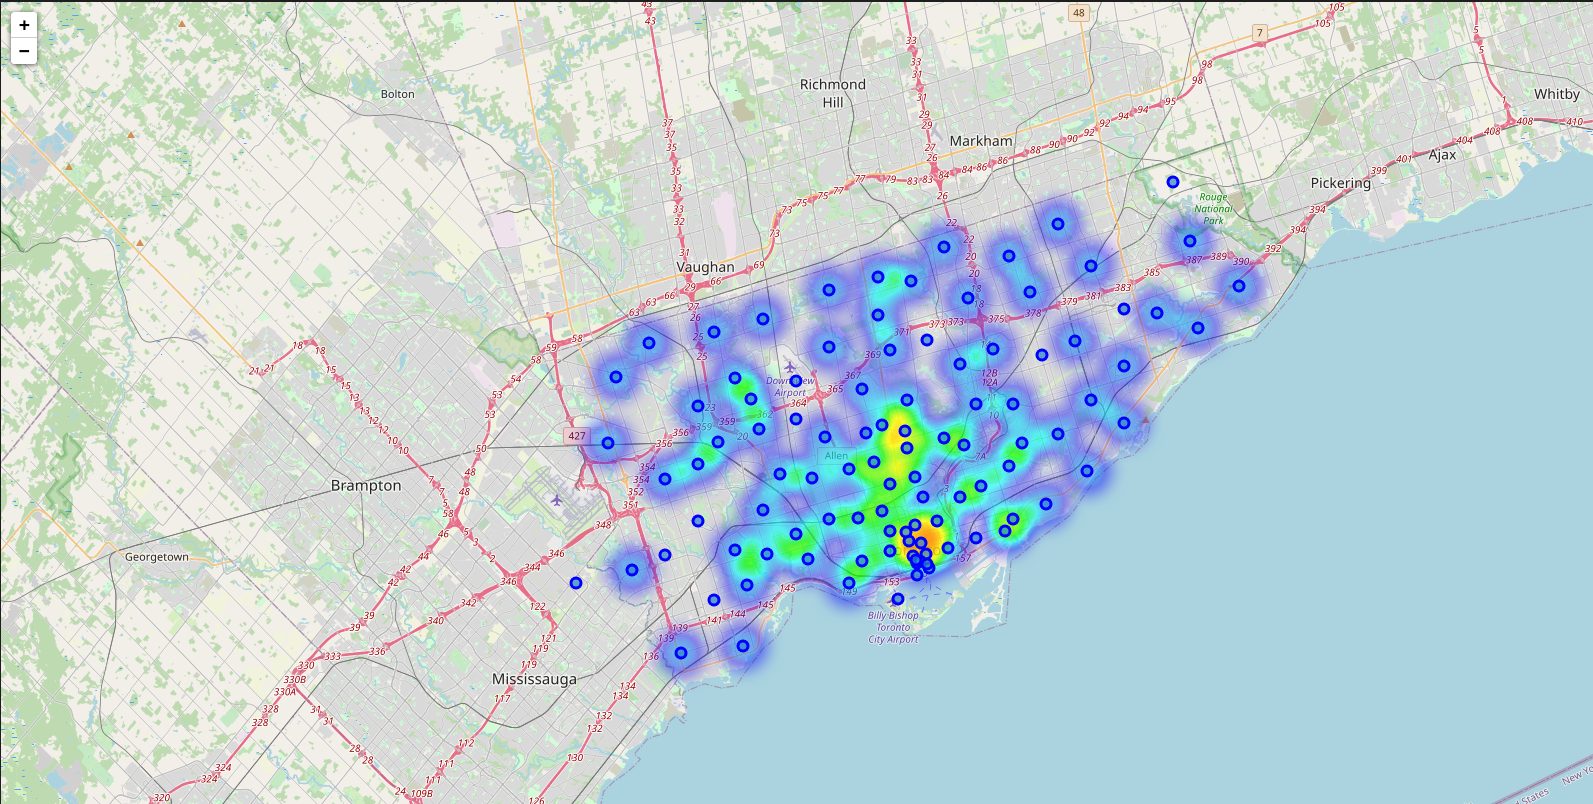

In [199]:
from IPython.display import Image

Image(filename="images/crime_map.png", width=800)

From the map we could see that most of the crimes are concentrated in the Downtown, however, at the same time there's a cluster around Central Toronto.

### Let's get data from Foursquare on school locations

In [93]:
from getpass import getpass

client_id = getpass("Foursquare Client ID:")
client_secret = getpass("Foursquare Client Secret:")

In [152]:
import requests


def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def format_address(location):
    address = ', '.join(location['formattedAddress'][:-2])
    return address

def get_schools_near_location(lat, lon, client_id, client_secret, radius=1000, limit=100):
    school_category_ids = ",".join([
        "4bf58dd8d48988d13d941735",  # High school
        "52e81612bcbc57f1066b7a45",  # Preschool
        "4f4533814b9074f6e4fb0106",  # Middle school
        "4f4533804b9074f6e4fb0105",  # Elementary school
        "52e81612bcbc57f1066b7a46",  # Private school
    ])

    version = '20180724'
    url = f"https://api.foursquare.com/v2/venues/explore?client_id={client_id}&client_secret={client_secret}&v={version}&ll={lat},{lon}&categoryId={school_category_ids}&radius={radius}&limit={limit}"

    results = requests.get(url).json()['response']['groups'][0]['items']
    
    venues = [{"id": item['venue']['id'],
               "name": item['venue']['name'],
               "categories": get_categories(item['venue']['categories']),
               "lat": item['venue']['location']['lat'],
               "long": item['venue']['location']['lng'],
               "address": format_address(item['venue']['location']),
               "distance": item['venue']['location']['distance']} for item in results]

    # Get ratings for each venue (school)
    for venue in venues:
        url = f"https://api.foursquare.com/v2/venues/{venue['id']}?client_id={client_id}&client_secret={client_secret}&v={version}"
        results = requests.get(url).json()
        try:
            venue["rating"] = results["venue"]["rating"]
        except:
            ...
        try:
            venue["likes"] = results["venue"]["likes"]["count"]
        except:
            ...

    venues = pd.DataFrame(venues)

    for col in ["rating", "likes", "distance"]:
        if col not in venues.columns:
            venues[col] = np.nan

    return venues

get_schools_near_location(latitude, longitude, client_id, client_secret)

id                           name  \
0  50d68a8cebca2e4ac8b91a9c                   DECA Ontario   
1  4bae1eacf964a5209c863be3       St Michaels Choir School   
2  59ff1993b1538e3a0b64c6e8  Keystone International School   
3  502a9c26e4b0880ff7863f56          GEOS Language Academy   
4  4c8e31f8f1e8ef3b0fb30bab  Kaplan International Colleges   

                                        categories        lat       long  \
0        [(High School, 4bf58dd8d48988d13d941735)]  43.651230 -79.383306   
1        [(High School, 4bf58dd8d48988d13d941735)]  43.655474 -79.377955   
2        [(High School, 4bf58dd8d48988d13d941735)]  43.650620 -79.376154   
3  [(Elementary School, 4f4533804b9074f6e4fb0105)]  43.650951 -79.375327   
4        [(High School, 4bf58dd8d48988d13d941735)]  43.645851 -79.382727   

                                            address  distance  rating  likes  
0  100 Richmond Street West (btwn Bay & University)       255     NaN    NaN  
1                                                         530     NaN    NaN  
2                                     23 Toronto St       703     NaN    NaN  
3                                                         748     NaN    NaN  
4           2 Bloor Street West, Cumberland Terrace       854     NaN    NaN

Now that we cat obtain schools for a location, let's get number of schools for each neighbourhood, their average distance, average rating, and average number of likes.

In [160]:
neighbourhood_schools: pd.DataFrame = pd.DataFrame()

for _, x in neighbourhoods.iterrows():
    schools = get_schools_near_location(x["Latitude"], x["Longitude"], client_id, client_secret)
    n_schools = len(schools)
    schools = schools.mean()
    neighbourhood_schools = neighbourhood_schools.append({
        "Postal Code": x["Postal Code"],
        "NumberOfSchools": n_schools,
        "AverageDistance": schools["distance"],
        "AverageRating": schools["rating"],
        "AverageLikes": schools["likes"],}, ignore_index=True)

neighbourhood_schools.head()

AverageDistance  AverageLikes  AverageRating  NumberOfSchools Postal Code
0            407.0           NaN            NaN              1.0         M1B
1              NaN           NaN            NaN              0.0         M1C
2            668.6           NaN            NaN              5.0         M1E
3            800.0           NaN            NaN              2.0         M1G
4            683.0           NaN            NaN              1.0         M1H

In [161]:
neighbourhood_crimes_schools = neighbourhood_crimes.merge(neighbourhood_schools, on="Postal Code")
neighbourhood_crimes_schools.head()

Postal Code      Borough                           Neighbourhood   Latitude  \
0         M1B  Scarborough                          Malvern, Rouge  43.806686   
1         M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2         M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3         M1G  Scarborough                                  Woburn  43.770992   
4         M1J  Scarborough                     Scarborough Village  43.744734   

   Longitude  CrimeRate  AverageDistance  AverageLikes  AverageRating  \
0 -79.194353   0.022603            407.0           NaN            NaN   
1 -79.160497   0.005929              NaN           NaN            NaN   
2 -79.188711   0.024962            668.6           NaN            NaN   
3 -79.216917   0.018398            800.0           NaN            NaN   
4 -79.239476   0.016436            372.5           NaN            NaN   

   NumberOfSchools  
0              1.0  
1              0.0  
2              5.0  
3              2.0  
4              2.0

Now we get data from Foursquare on the schools in each neighbours hood, combined with neighbourhood data and their crime data, store everything in one data frame.

In [162]:
neighbourhood_crimes_schools.to_csv("toronto_neighbourhoods_crimes_schools.csv", index=False)

### Cluster the neighbourhoods based on their 

In [163]:
from sklearn.cluster import KMeans

Data pre-processing

In [180]:
neighbourhoods_clusters = neighbourhood_crimes_schools.copy()
# Remove AverageRating and AverageLikes since API quota was exceeded to get those
neighbourhoods_clusters.drop(columns=["AverageRating", "AverageLikes"], inplace=True)
neighbourhoods_clusters = neighbourhoods_clusters[neighbourhoods_clusters['AverageDistance'].notna()]

neighbourhoods_clustering = neighbourhoods_clusters[["CrimeRate", "AverageDistance", "NumberOfSchools"]]
neighbourhoods_clustering.head()

CrimeRate  AverageDistance  NumberOfSchools
0   0.022603            407.0              1.0
2   0.024962            668.6              5.0
3   0.018398            800.0              2.0
4   0.016436            372.5              2.0
5   0.014058            632.0              3.0

In [181]:
from sklearn.preprocessing import StandardScaler

X = neighbourhoods_clustering.values
X = StandardScaler().fit_transform(X)
X[:5]

array([[ 1.14259192, -1.74650834, -1.17754964],
       [ 1.4031588 ,  0.11735802,  0.95589324],
       [ 0.67817292,  1.05356613, -0.64418892],
       [ 0.46147973, -1.99231641, -0.64418892],
       [ 0.19877267, -0.14341227, -0.1108282 ]])

Run K-Means to cluster neighbourhoods

In [182]:
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbourhoods_clustering)

kmeans.labels_[:10]

array([2, 3, 4, 2, 3, 0, 0, 4, 4, 3], dtype=int32)

In [183]:
neighbourhoods_clusters["Cluster Labels"] = kmeans.labels_
neighbourhoods_clusters.head()

Postal Code      Borough                                Neighbourhood  \
0         M1B  Scarborough                               Malvern, Rouge   
2         M1E  Scarborough            Guildwood, Morningside, West Hill   
3         M1G  Scarborough                                       Woburn   
4         M1J  Scarborough                          Scarborough Village   
5         M1K  Scarborough  Kennedy Park, Ionview, East Birchmount Park   

    Latitude  Longitude  CrimeRate  AverageDistance  NumberOfSchools  \
0  43.806686 -79.194353   0.022603            407.0              1.0   
2  43.763573 -79.188711   0.024962            668.6              5.0   
3  43.770992 -79.216917   0.018398            800.0              2.0   
4  43.744734 -79.239476   0.016436            372.5              2.0   
5  43.727929 -79.262029   0.014058            632.0              3.0   

   Cluster Labels  
0               2  
2               3  
3               4  
4               2  
5               3

The clusters themselves are not very informative, so we can gauge the cluster centers (means of the cluster) to understand what they represent

In [189]:
np.set_printoptions(suppress=True, precision=4)
kmeans.cluster_centers_

array([[  0.0138, 548.2675,   3.1053],
       [  0.0077, 882.5238,   1.8571],
       [  0.0146, 380.7604,   2.0000],
       [  0.0119, 671.3225,   4.1852],
       [  0.0119, 777.9591,   2.8750]])

From the above clusters, we can see that there's cluster with larger distance and fewer schools, or moderate distance but more schools, etc. Let's describe each cluster:

In [191]:
cluster_names = {
    0: "Moderate distance, moderate school density",
    1: "Large distance, low school density",
    2: "Low distance, low school density",
    3: "Large distance, large school density",
    4: "Large distance, moderate school density",
}

Update the dataframe with the cluster names

In [192]:
neighbourhoods_clusters["Cluster Names"] = neighbourhoods_clusters["Cluster Labels"].map(cluster_names)
neighbourhoods_clusters.head()

Postal Code      Borough                                Neighbourhood  \
0         M1B  Scarborough                               Malvern, Rouge   
2         M1E  Scarborough            Guildwood, Morningside, West Hill   
3         M1G  Scarborough                                       Woburn   
4         M1J  Scarborough                          Scarborough Village   
5         M1K  Scarborough  Kennedy Park, Ionview, East Birchmount Park   

    Latitude  Longitude  CrimeRate  AverageDistance  NumberOfSchools  \
0  43.806686 -79.194353   0.022603            407.0              1.0   
2  43.763573 -79.188711   0.024962            668.6              5.0   
3  43.770992 -79.216917   0.018398            800.0              2.0   
4  43.744734 -79.239476   0.016436            372.5              2.0   
5  43.727929 -79.262029   0.014058            632.0              3.0   

   Cluster Labels                            Cluster Names  
0               2         Low distance, low school density  
2               3     Large distance, large school density  
3               4  Large distance, moderate school density  
4               2         Low distance, low school density  
5               3     Large distance, large school density

Display the resulting clusters

In [195]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster_label, cluster_name in zip(neighbourhoods_clusters['Latitude'], neighbourhoods_clusters['Longitude'], neighbourhoods_clusters['Cluster Labels'], neighbourhoods_clusters['Cluster Names']):
    label = folium.Popup(f"Cluster {cluster_label}: {cluster_name}", parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster_label-1],
        fill=True,
        fill_color=rainbow[cluster_label-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

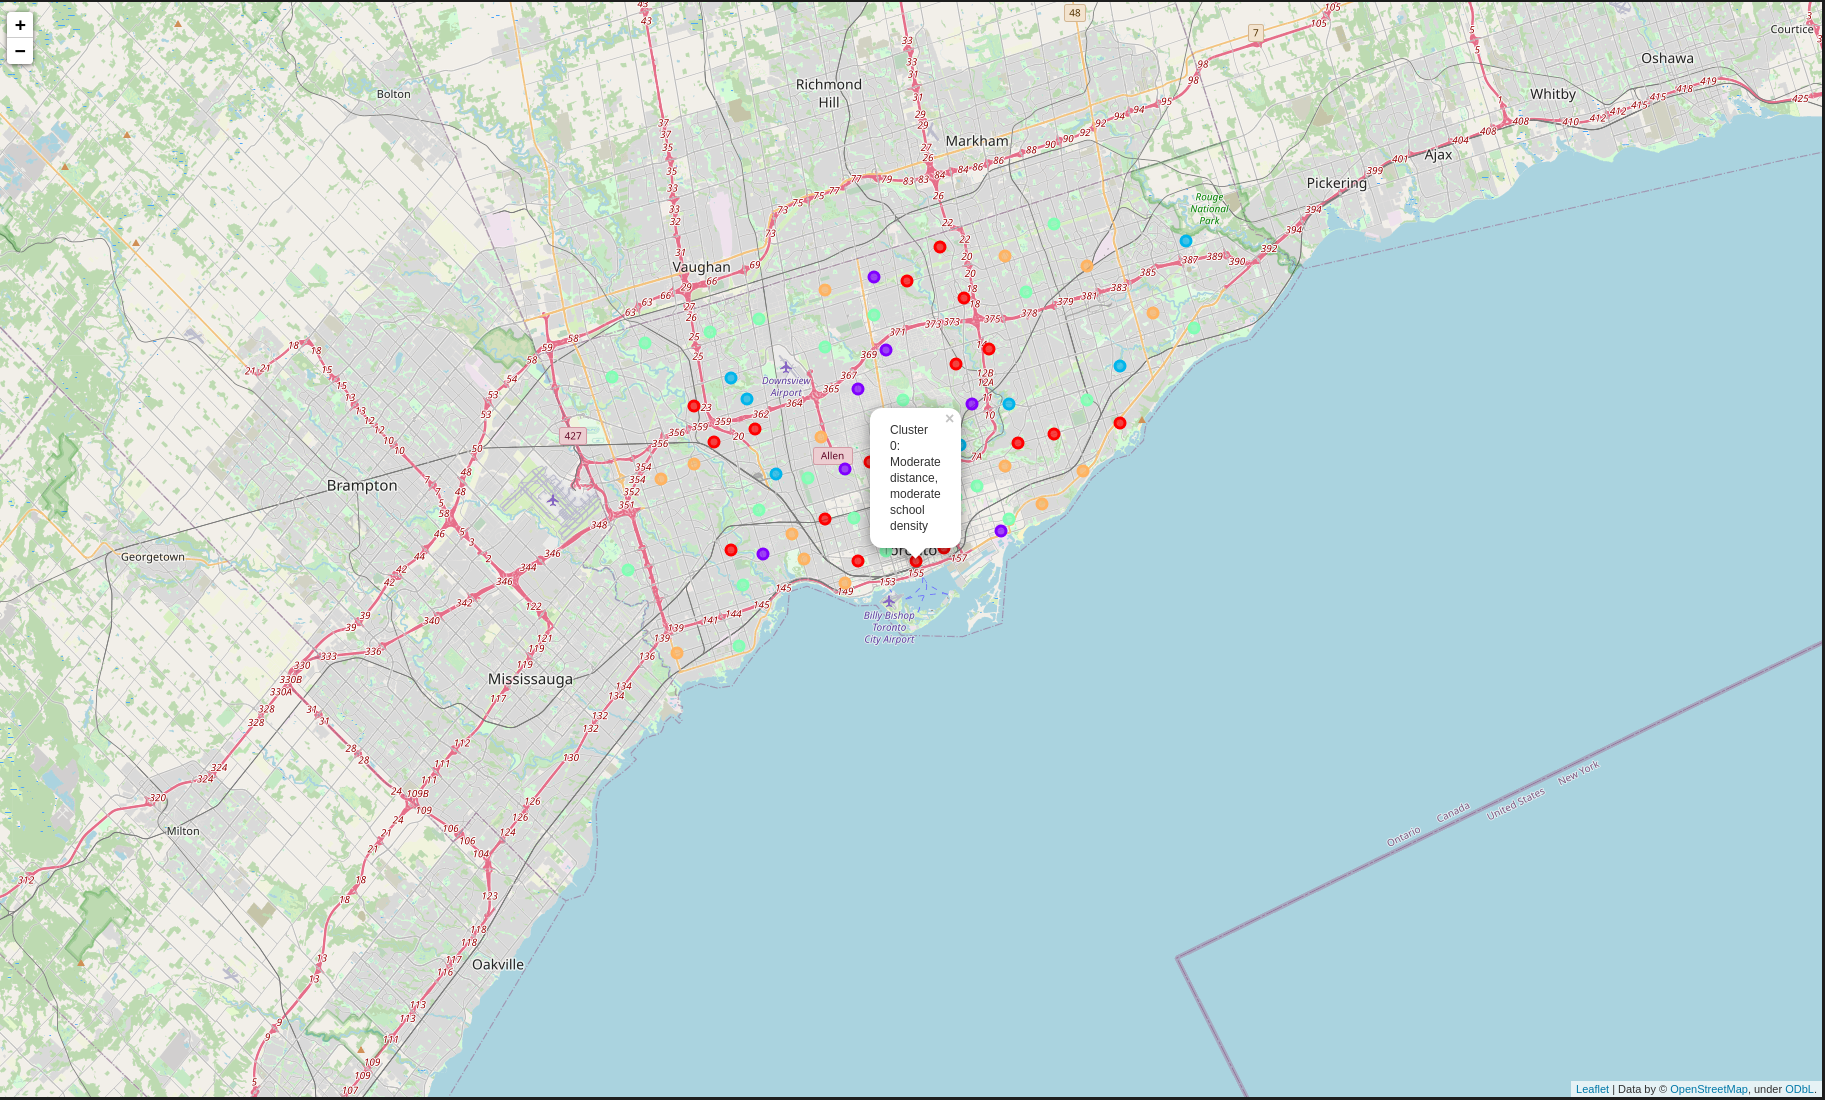

In [200]:
Image(filename="images/cluster_map.png", width=800)

Now we can explore each neighbourhood and see what school density and average distance there is. Crime data didn't seem to impact clustering, since all of the clusters had approx. the same mean rates.

## Results <a id="res"></a>

The results showed that school locations had more influence on clustering of neighbourhoods than crimes reported. There was probably higher crime rates in higher density areas, or richer areas.

Overall, the analysis has been done and a map with neighbourhood categories was presented to allow the user to click on neighbourhood and understand its advantages or disadvantages.

## Discussion <a id="disc"></a>

### Future development
* Crime data didn't seem to have had a lot of impact on clustering. Try to see if maybe need to filter by crime type, or maybe only consider that last year.
* When available (Foursquare API quota), add school rating and likes into the data and run clustering using those too and see how it changes the results.

## Conclusion <a id="concl"></a>

In conclusion, combining data from multiple sources (Wikipedia, Foursquare, Toronto Police Open Dataset) we could learn a lot of information about certain neighbourhoods.

With the combined information we could use Machine Learning algorithms (K-Means) to cluster neighbourhoods into different subcategories.

We could then analyze the clusters (categories) to come up with a description for the category and inform the users of the system (stakeholders) with additional data about certain neighbourhoods.

The users could use this extra data to make informed decisions when selecting neighbourhoods for living.